## Bootstrapping Errors

Lets revist the example I showed of the sine curve:

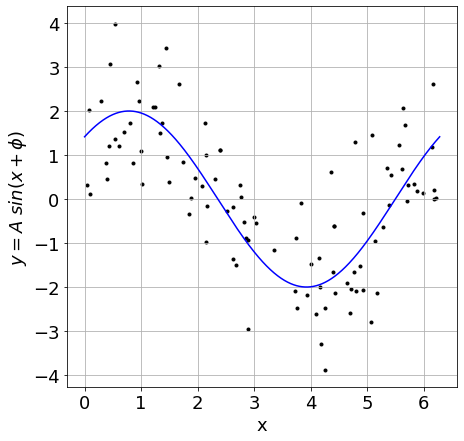

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
%matplotlib inline

def sine(x,amp,phase):
    """
    x: input in radians
    amp: amplitude of sine curve
    phase: phase of the sine curve in radians
    """
    return amp*np.sin(x+phase)

#generate 100 random points between 0 and 2 pi
N_samp=100
x=np.random.random(N_samp)*2*np.pi

#set amplitude and phase
amp=2.
phase=np.pi/4

y=sine(x,amp,phase)

#create normally distributed noise with some standard deviation
std=1
y_noise=np.random.randn(N_samp)*std
#plot the data
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(7,7))
plt.scatter(x,y+y_noise,c='k',marker='.',label='_nolabel_')
xcont=np.linspace(0,2*np.pi,1000)
plt.plot(xcont,sine(xcont,amp,phase),c='b',label='True')
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$y=A\ sin(x+\phi)$')
plt.show()

One useful thing you can do with bootstrap sampling, is you can use it to estimate errors on the paramaters of a function that you want to fit. We can very easily create a function to bootstrap these errors in Python:

Bootstrap Amplitude=1.8203 +/- 0.1433, Difference from True Value=0.1797
Bootstrap Phase=0.7414 +/- 0.0777, Difference from True Value=0.0440


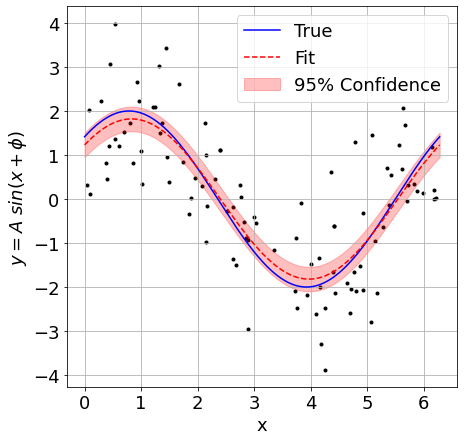

In [2]:
def bootstrap_fit(x,y,y_noise,f,N_params,N,use_noise=False):
    """
    x: x data to fit
    y: ydata to fit
    y_noise: noise added to the y data
    f: fucntion that is being fitted
    N_params: number of paramaters being fit in the function
    N: number of iterations in the bootstrap
    use_noise: add sigma term to the fit, default is False
    """
    params_all=np.zeros((N,N_params))
    for i in range(N):
        #create random indexes to draw from the data
        idx=np.random.randint(0,len(x),len(x))
        
        #fit the data
        if use_noise:
            params,cov=curve_fit(f,x[idx],y[idx]+y_noise[idx],sigma=y_noise[idx])
        else:
            params,cov=curve_fit(f,x[idx],y[idx]+y_noise[idx])
        
        #save the params
        params_all[i,:]=params
    #get the average paramaters during fitting
    params_avg=np.mean(params_all,axis=0)
    
    #get the standard deviation in the paramaters
    params_std=np.std(params_all,axis=0)
    
    return params_avg,params_std

params,params_std=bootstrap_fit(x,y,y_noise,sine,2,1000)

print('Bootstrap Amplitude=%.4f +/- %.4f, Difference from True Value=%.4f' % (params[0],params_std[0],abs(amp-params[0])))
print('Bootstrap Phase=%.4f +/- %.4f, Difference from True Value=%.4f' % (params[1],params_std[1],abs(phase-params[1])))


#plot the fit
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(7,7))
plt.scatter(x,y+y_noise,c='k',marker='.',label='_nolabel_')

xcont=np.linspace(0,2*np.pi,1000)
plt.plot(xcont,sine(xcont,amp,phase),c='b',label='True')
plt.plot(xcont,sine(xcont,*params),'--',c='r',label='Fit')

#do error propogation to get 95% confidence interval
#wont go into detail about this, see other portions of the workshop
y_fit_err=np.sqrt((np.sin(xcont+params[1])*params_std[0])**2+(params[0]*np.cos(xcont+params[1])*params_std[1])**2)
plt.fill_between(xcont,sine(xcont,*params)-1.95*y_fit_err,sine(xcont,*params)+1.95*y_fit_err,color='r',alpha=0.25,
                label='95% Confidence')

plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$y=A\ sin(x+\phi)$')
plt.show()